In [ ]:
import os

small_dataset = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
small_dataset_dir = '/lambda/nfs/main-filesystem/OCT_by_class' ## change this based on your own google drive directory
#small_dataset_dir = '/content/drive/MyDrive/Third Year/Summer/APS360/APS360 Project - Group 7/Code/small_dataset' ## change this based on your own google drive directory
#small_dataset_dir = '/content/drive/MyDrive/APS360 Project - Group 7/Code/small_dataset'

In [ ]:
def num_images(dir, folders):
    print(f"Number of images in each folder:")
    for folder in folders:
        path = os.path.join(dir, folder)
        if os.path.isdir(path):
            num_files = len(os.listdir(path))
            print(f"{folder}: {num_files}")
        else:
            print(f"Folder '{folder}' does not exist in the dataset directory.")

In [ ]:
num_images(small_dataset_dir, small_dataset)

Number of images in each folder:
CNV: 3000
DME: 3000
DRUSEN: 3000
NORMAL: 3000


In [ ]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision import models, transforms, datasets
from torch import nn

resnet_model = models.resnet152(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1]) # remove last classification layers
resnet_model.to(device)
resnet_model.eval()

In [ ]:
from PIL import Image
import cv2
import numpy as np
import torch

def local_binary_pattern(image, P, R): # manual LBP function because LBP package from scikit-learn was not compatible on Lambda cloud
    height, width = image.shape
    lbp = np.zeros_like(image, dtype=np.uint8)

    for i in range(R, height - R):
        for j in range(R, width - R):
            center_pixel = image[i, j]
            binary_code = []

            for p in range(P):
                theta = 2 * np.pi * p / P
                x = int(i + R * np.cos(theta))
                y = int(j - R * np.sin(theta))

                if image[x, y] >= center_pixel:
                    binary_code.append(1)
                else:
                    binary_code.append(0)

            lbp[i, j] = sum([binary_code[k] * (2**k) for k in range(len(binary_code))])

    return lbp

def extract_texture_and_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # edge detection using Sobel filter, https://how.dev/answers/sobel-operator-in-digital-image-processing
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)  # Sobel in x-direction
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)  # Sobel in y-direction
    edges = np.hypot(sobel_x, sobel_y)  # combine gradients

    # https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html
    lbp = local_binary_pattern(img, P=8, R=1)  # texture descriptors using Uniform Local Binary Pattern (LBP)

    edges_flat = edges.flatten()
    lbp_flat = lbp.flatten()

    combined_features = np.concatenate((edges_flat, lbp_flat), axis=0) # combine all features
    return combined_features

def extract_features(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB') # convert to rgb because resnet works with rgb
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        features = model(image)  # extract features from resnet
        features = features.view(features.size(0), -1)  # flatten to vector
    return features.cpu().numpy() # convert to numpy for svm


def extract_combined_features(image_path, resnet_model, transform, device):
    resnet_features = extract_features(image_path, resnet_model, transform)
    texture_edge_features = extract_texture_and_edges(image_path)

    # combine features (flatten resnet + texture/edge)
    combined_features = np.concatenate((resnet_features.flatten(), texture_edge_features), axis=0)
    return combined_features

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization for resnet
])

dataset = datasets.ImageFolder(small_dataset_dir, transform=data_transform)

In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = []
labels = []

# extract features in batches to save RAM
batch_size = 256
diseases = os.listdir(small_dataset_dir)

for disease in diseases:
    disease_dir = os.path.join(small_dataset_dir, disease)

    image_paths = [
        os.path.join(disease_dir, img) for img in os.listdir(disease_dir)
        if os.path.isfile(os.path.join(disease_dir, img))
    ]

    for i in tqdm(range(0, len(image_paths), batch_size), desc=f"Processing {disease} Images", leave=False):
        batch_paths = image_paths[i:i+batch_size]

        batch_features = []
        batch_labels = []

        for image_path in batch_paths:
            resnet_feature = extract_features(image_path, resnet_model, data_transform, device)
            texture_edge_feature = extract_texture_and_edges(image_path)

            combined_features = np.concatenate((resnet_feature.flatten(), texture_edge_feature), axis=0)
            batch_features.append(combined_features)
            batch_labels.append(disease)

        features.extend(batch_features)
        labels.extend(batch_labels)

        torch.cuda.empty_cache()

features = np.array(features)
labels = np.array(labels)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42) # split features and labels into 70% training and 30% testing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')  # rbf based on proposal

In [ ]:
svm_rbf.fit(X_train_pca, y_train)# train SVM

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [ ]:
y_pred = svm_rbf.predict(X_test_pca)

In [ ]:
# accuracy test

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5436


Confusion Matrix:
[[631 116 105  54]
 [238 447 137  99]
 [164 111 422 168]
 [110 122 219 457]]


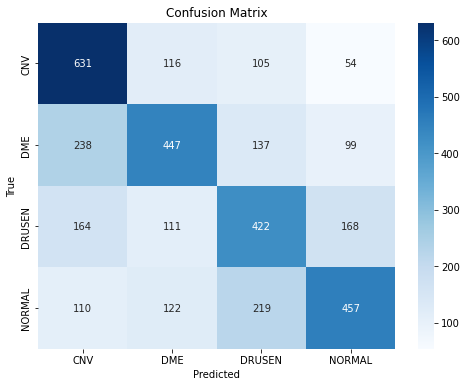

In [ ]:
# confusion matrix test

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=diseases)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

         CNV       0.55      0.70      0.62       906
         DME       0.56      0.49      0.52       921
      DRUSEN       0.48      0.49      0.48       865
      NORMAL       0.59      0.50      0.54       908

    accuracy                           0.54      3600
   macro avg       0.54      0.54      0.54      3600
weighted avg       0.55      0.54      0.54      3600

